In [1]:
# ==============================================================================
# Cell 1: Imports & Setup
# ==============================================================================
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

# For smart label placement in graphs
# (If you get an error, run: pip install adjustText)
try:
    from adjustText import adjust_text
except ImportError:
    print("⚠️ 'adjustText' library not found. Install it via 'pip install adjustText' for better labels.")
    def adjust_text(*args, **kwargs): pass # Dummy function if library missing

# Define Paths
PROCESSED_DATA_PATH = '../data/processed'
OUTPUT_PATH = '../output'
FIGURES_PATH = '../output/figures'

# Ensure output directories exist
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

print("✅ Libraries imported and paths set.")

⚠️ 'adjustText' library not found. Install it via 'pip install adjustText' for better labels.
✅ Libraries imported and paths set.


In [2]:
# ==============================================================================
# Cell 2: Load Data & Construct Graph
# ==============================================================================
# Load the edges we collected in Phase 1
edges_path = os.path.join(PROCESSED_DATA_PATH, 'network_edges.csv')

if not os.path.exists(edges_path):
    raise FileNotFoundError(f"❌ File not found: {edges_path}. Did you run Phase 1?")

df_edges = pd.read_csv(edges_path)
print(f"Loaded {len(df_edges)} edges.")

# Construct the Graph
# We use a Directed Graph (DiGraph) because features are directional 
# (Main Artist -> Featured Artist)
G = nx.from_pandas_edgelist(df_edges, 'source', 'target', create_using=nx.DiGraph())

print(f"Network constructed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Quick check: Is the graph connected?
if nx.is_weakly_connected(G):
    print("The network is fully connected (everyone is linked to everyone).")
else:
    print(f"The network has {nx.number_weakly_connected_components(G)} disconnected islands.")
    # If disconnected, we usually focus analysis on the largest island
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    print(f"The largest island has {len(largest_cc)} nodes.")

Loaded 69 edges.
Network constructed with 51 nodes and 60 edges.
The network is fully connected (everyone is linked to everyone).


In [3]:
# ==============================================================================
# Cell 3: Centrality Analysis (The Super-Connectors)
# ==============================================================================
# Who are the most important artists in this ecosystem?

# 1. Degree Centrality (Popularity)
# Simply counts how many connections an artist has.
degree_dict = dict(G.degree(G.nodes()))
sorted_degree = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)

print("\n--- Top 5 Most Connected Artists (Degree) ---")
for artist, score in sorted_degree[:5]:
    print(f"{artist}: {score} connections")

# 2. Betweenness Centrality (The Bridges)
# Identifies artists who connect different cliques (e.g., connecting Atlanta to West Coast).
betweenness_dict = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness_dict.items(), key=lambda item: item[1], reverse=True)

print("\n--- Top 5 Bridge Artists (Betweenness) ---")
for artist, score in sorted_betweenness[:5]:
    print(f"{artist}: {score:.4f}")

# Save these metrics to a dataframe for later use
df_centrality = pd.DataFrame({
    'Artist': [x[0] for x in sorted_degree],
    'Degree': [x[1] for x in sorted_degree],
    'Betweenness': [betweenness_dict[x[0]] for x in sorted_degree]
})


--- Top 5 Most Connected Artists (Degree) ---
Kanye West: 28 connections
Kendrick Lamar: 12 connections
Drake: 12 connections
Future: 9 connections
J. Cole: 5 connections

--- Top 5 Bridge Artists (Betweenness) ---
Kendrick Lamar: 0.0159
Drake: 0.0129
Kanye West: 0.0088
J. Cole: 0.0000
Amber Coffman: 0.0000


In [4]:
# ==============================================================================
# Cell 4: Community Detection (The Scenes)
# ==============================================================================
# We use the Louvain Algorithm to find "clusters" or "scenes".
# Louvain works best on Undirected graphs.

G_undirected = G.to_undirected()

# Run Louvain Algorithm
# resolution: Controls size of communities (1.0 is standard)
communities = nx.community.louvain_communities(G_undirected, seed=42, resolution=1.0)

# Assign a Community ID to every artist
artist_community_map = {}
for i, community_set in enumerate(communities):
    for artist in community_set:
        artist_community_map[artist] = i

print(f"✅ Detected {len(communities)} distinct communities/scenes.")

# Analyze the Communities
print("\n--- Community Breakdown ---")
community_data = []

for i, community in enumerate(communities):
    # Find the "leader" of the community (highest degree)
    leader = max(community, key=lambda x: degree_dict[x])
    size = len(community)
    print(f"Community {i}: {size} artists. (Key Artist: {leader})")
    # print(f"   Members: {list(community)[:5]}...") # Uncomment to see members
    
    community_data.append({'Community_ID': i, 'Leader': leader, 'Size': size, 'Members': list(community)})

# Save this map! We need it for Phase 4 (Synthesis).
df_communities = pd.DataFrame(list(artist_community_map.items()), columns=['Artist', 'Community_ID'])
comm_save_path = os.path.join(PROCESSED_DATA_PATH, 'artist_communities.csv')
df_communities.to_csv(comm_save_path, index=False)
print(f"\nSaved community mapping to: {comm_save_path}")

✅ Detected 5 distinct communities/scenes.

--- Community Breakdown ---
Community 0: 5 artists. (Key Artist: J. Cole)
Community 1: 8 artists. (Key Artist: Kendrick Lamar)
Community 2: 10 artists. (Key Artist: Drake)
Community 3: 21 artists. (Key Artist: Kanye West)
Community 4: 7 artists. (Key Artist: Future)

Saved community mapping to: ../data/processed/artist_communities.csv


✅ Visualization saved to: ../output/figures/network_visualization.png


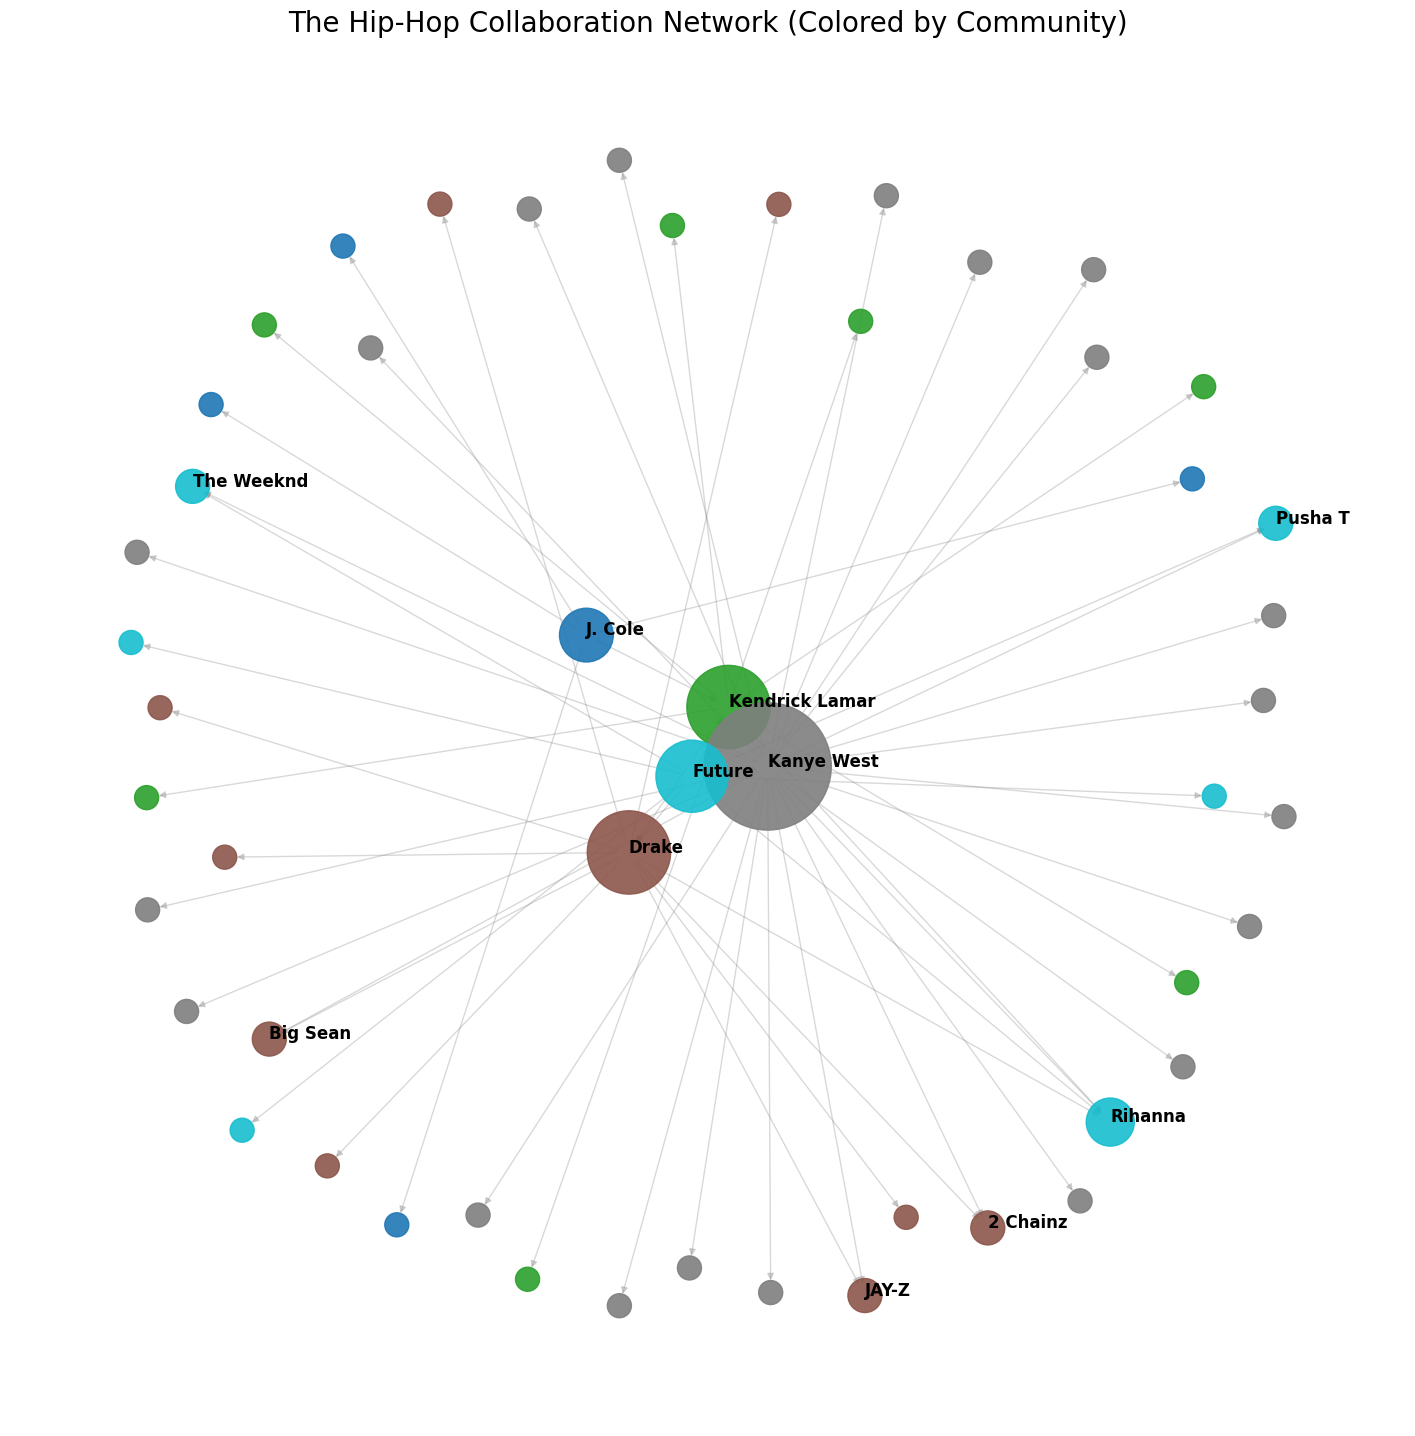

In [5]:
# ==============================================================================
# Cell 5: Network Visualization
# ==============================================================================
# Let's draw the map. We color nodes based on their Community ID.

plt.figure(figsize=(18, 18))

# 1. Layout (Positioning the nodes)
# k=0.3 pushes nodes apart. iterations=50 gives it time to settle.
pos = nx.spring_layout(G, k=0.25, iterations=50, seed=42)

# 2. Colors
# Map the community ID to a color list
colors = [artist_community_map[node] for node in G.nodes()]

# 3. Sizes
# Size nodes based on their connectivity (Degree)
sizes = [degree_dict[node] * 300 for node in G.nodes()]

# 4. Draw
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, cmap=plt.cm.tab10, alpha=0.9)

# 5. Labels (Only label the important artists to avoid clutter)
# We label artists with Degree > 1 (Seed artists + major features)
labels_to_show = {node: node for node in G.nodes() if degree_dict[node] > 1}

texts = []
for node, (x, y) in pos.items():
    if node in labels_to_show:
        texts.append(plt.text(x, y, node, fontsize=12, fontweight='bold'))

# Adjust text to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.title("The Hip-Hop Collaboration Network (Colored by Community)", fontsize=20)
plt.axis('off')

# Save
fig_path = os.path.join(FIGURES_PATH, 'network_visualization.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Visualization saved to: {fig_path}")
plt.show()